# VQC Challenge

In this challenge, you will use [Pennylane](https://github.com/PennyLaneAI/pennylane) and [Amazon Braket](https://github.com/aws/amazon-braket-examples) to implement a variational quantum classifier (VQC) to take on a supervised learning problem based on the work of [Havlíček et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf). Complete each of the four TODOs in this notebook to construct and train a QML model to solve the binary classification task. You can use the `gen_binary.py` script to generate a new train/test dataset, and further test your model.

A central feature of Amazon Braket is that its remote simulator can execute multiple circuits in parallel. This capability can be harnessed in PennyLane during circuit training, which requires lots of variations of a circuit to be executed. Hence, the PennyLane-Braket plugin provides a method for scalable optimization of large circuits with many parameters. After validating your implementation and successfully training using a local simulator, enable [qBraid quantum jobs](https://qbraid-qbraid.readthedocs-hosted.com/en/latest/cli/jobs.html) and test your binary classifier on remote quantum hardware using the [Amazon Braket Pennylane plugin](https://github.com/aws/amazon-braket-pennylane-plugin-python). See the resources linked below for more.

*Important*:  Your final model must be tested with on a remote quantum device using the Amazon Braket Pennylane plugin. Submissions that do not interface with [Amazon Braket supported devices](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html) will not be eligible to be ranked on the leaderboard.

#### Pennylane Resources:

- [Quantum Embedding](https://pennylane.ai/qml/glossary/quantum_embedding.html)
- [Quantum Feature Map](https://pennylane.ai/qml/glossary/quantum_feature_map.html)
- [Circuit Ansatz](https://pennylane.ai/qml/glossary/circuit_ansatz.html)
- [Variational Circuit](https://pennylane.ai/qml/glossary/variational_circuit.html)
- [Quantum Gradient](https://pennylane.ai/qml/glossary/quantum_gradient.html)
- [Variational Quantum Classifier](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html)
- [PennyLane-Braket Plugin](https://amazon-braket-pennylane-plugin-python.readthedocs.io/en/latest/)
- [Computing gradients in parallel with Amazon Braket](https://pennylane.ai/qml/demos/braket-parallel-gradients.html)

#### Amazon Braket Resources:

- [Use PennyLane with Amazon Braket](https://docs.aws.amazon.com/braket/latest/developerguide/hybrid.html)
- [Amazon Braket examples: hybrid quantum algorithms](https://github.com/aws/amazon-braket-examples/tree/main/examples/hybrid_quantum_algorithms)

#### qBraid Resources:

- [qBraid demo notebooks: quantum jobs](https://github.com/qBraid/qbraid-lab-demo/blob/main/qbraid_quantum_jobs.ipynb)
- [qBraid CLI: quantum jobs commands](https://qbraid-qbraid.readthedocs-hosted.com/en/latest/cli/jobs.html)

In [1]:
!qbraid jobs disable haqs  # enable quantum jobs

Disable successful. You are now submitting quantum jobs with your own AWS credentials.

To re-enable, run: `qbraid jobs enable haqs`


In [2]:
!qbraid jobs enable haqs  # enable quantum jobs

Successfully enabled qBraid Quantum Jobs in the haqs environment.
Every AWS job you run will now be submitted through the qBraid API, so no access keys are necessary. 

To disable, run: `qbraid jobs disable haqs`


In [3]:
# check remaining qBraid credits
!qbraid jobs get-credits

You have 1457.5291248799904 remaining qBraid credits.


In [4]:
TEAM_NAME = "TheQuantumSquad007"  # enter team name

In [5]:
import warnings

warnings.filterwarnings("ignore")

import csv
import json
import os
import time
from itertools import chain, combinations

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

## Load and visualize dataset

To generate the data, two random vectors in the X-Z plane of the Bloch sphere are chosen. Around these two vectors, we randomly sample two sets of quantum data points; the task is to learn to distinguish the two sets.

This binary dataset has been artificially generated to be perfectly classifiable using a suitable feature map.

In [140]:
%run gen_binary.py  # uncomment to generate new train/test dataset

In [6]:
DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_samples = 1000  # number of train/test samples 
# we change the n_samples to follow the testing procedure
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, train_size=(0.8))
# testing procedure with 800 train data, 200 test data

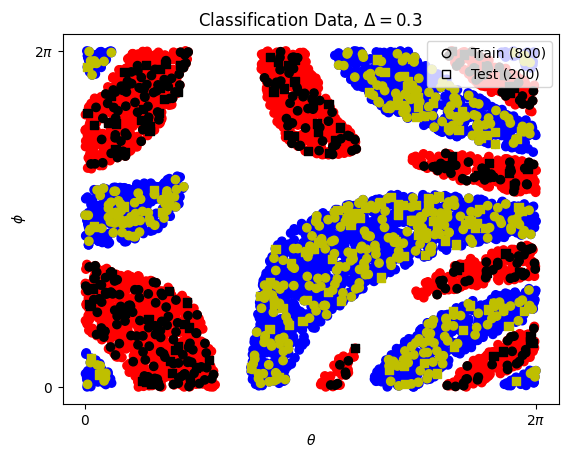

In [7]:
split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

plt.scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
plt.scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train])
plt.scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test])
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
plt.legend(handles=[label_circle, label_square], loc="upper right")
plt.title(f"Classification Data, $\Delta = {delta}$")
plt.savefig(DATA_PATH + "binary_landscape.png")
plt.show()

An arbitrary single qubit state can be written:

$$ \left| \psi \right\rangle = e^{i \gamma} \big(\cos \frac{\theta}{2}\left|0\right\rangle + e^{i \phi} \sin \frac{\theta}{2}\left|1\right\rangle \big) $$ 

where $\theta$, $\phi$ and $\gamma$ are real numbers. The numbers $0 \leq \theta \leq \pi$ and $0 \leq \phi \leq 2\pi$ define a point on the Bloch sphere.

## Construct data encoding feature map with entanglement $\left| \Phi(x_i) \right\rangle \left\langle \Phi(x_i) \right|  $

The feature map is an injective encoding of the classical data $\textbf{x} \in {\rm I\!R}^d$ into a quantum state $\left| \Phi \right\rangle \left\langle \Phi \right|$. Implement the following unitary feature map onto $n$-qubits, where $H$ denotes the conventional Hadamard gate:

$$\left|\Phi(\textbf{x})\right\rangle = \mathcal{U}_{\Phi(\textbf{x})}\left|0\right\rangle^{\otimes n} = U_{\Phi(\textbf{x})}H^{\otimes n} U_{\Phi(\textbf{x})}H^{\otimes n} \left|0\right\rangle^{\otimes n}$$
where,
$$U_{\Phi(\textbf{x})} = \exp\bigg(i \sum_{S \subseteq [n]} \phi_S(\textbf{x}) \prod_{i \in S} Z_i \bigg)$$
where the $2^n$ coefficients $\phi(\textbf{x}) \in {\rm I\!R}$ are now non-linear functions of the input data $\textbf{x} \in {\rm I\!R}^n$. In general, maps with low degree expansions $|S| \leq d$ can be implemented efficiently. As in the original paper, use $n=d=2$.

In [8]:
def powerset(iterable, mx):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    pset = chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
    return [l for l in list(pset) if len(l) == mx]

In [9]:
n_wires = 2  # number of qubits
S_size = 2  # number of interactions considered
depth = 2  # number of layers in ansatz  
# we are using the same depth as in the paper
pset = powerset(range(n_wires), S_size)

In [10]:
pset

[(0, 1)]

In [11]:
def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])

Considering only Ising type interactions ($d=2$), the unitaries are generated from one- and two- big gates of the form

$$U_{\phi_{\{k\}}(\textbf{x})} = \exp\big(i\phi_{\{k\}}(\textbf{x})Z_k \big)$$
$$U_{\phi_{\{l,m\}}(\textbf{x})} = \exp\big(i\phi_{\{k,l\}}(\textbf{x})Z_kZ_l\big)$$


where we have followed Havlíček et al. and chosen $\phi_{\{ i \}} = x_i$ and $\phi_{\{ 1,2 \}} = (\pi - x_1)(\pi - x_2)$ 

### <span style="color:red">TODO (1): Fix incorrect feature map</span>

In [12]:
def feature_map(x):
    """Short depth feature map with entanglement

    Args:
        x : shape (3,) tensor containing one encoded data vector
    """
    
    ## replicating from the gen_binary.py feature_map, since this is important to relocate the data to qubits based on the binary creation
    ## not sure why since the paper is using RZ instead of RX
    for j in range(S_size):
        for i in range(n_wires):
            qml.Hadamard(wires=i)

        for i in range(n_wires):
            qml.RX(x[i], wires=i)

        for s in pset:
            qml.CNOT(wires=s)
            qml.RX(x[2], wires=s[1])
            qml.CNOT(wires=s)
    
    """
    for j in range(S_size):
        for i in range(n_wires):
            qml.Hadamard(wires=i)

        for i in range(n_wires):
            qml.RZ(-2 * x[i], wires=i)

        for s in pset:
            qml.CNOT(wires=s)
            qml.RZ(-2 * x[2], wires=s[1])
            qml.CNOT(wires=s)
    """     

## Construct short-depth discriminator circuit $W(\theta)$

The general short-depth circuit to define a seperating hyperplane is comprised of the following sequence of single qubit and multi-qubit gates:

$$ W(\theta) = U_{loc}^{(l)}(\theta_l)U_{ent}...U_{loc}^{(2)}(\theta_2)U_{ent}U_{loc}^{(1)}(\theta_1) $$


Apply a circuit of $l$ repeated entanglers and interleave them with layers comprised of local single qubit rotations:

$$ U_{loc}^{(t)}(\theta_t) = \otimes_{m=1}^n U(\theta_{m,t}) \quad \text{and} \quad U(\theta_{m,t}) = \exp\bigg(i \frac{1}{2}\theta_{m,t}^z Z_m\bigg) \exp\bigg(i \frac{1}{2}\theta_{m,t}^y Y_m\bigg) $$

parameterized by $\theta_t \in {\rm I\!R}^{2n}$ and $\theta_{i,t} \in {\rm I\!R}^{2}$. Implement a feature map that uses entangling unitaries comprised of products of controlled-Z phase gates $CZ(i,j)$ between qubits $i$ and $j$.

$$ U_{ent} = \prod_{(i,j) \in E} CZ(i,j) $$ 

### <span style="color:red">TODO (2): Fix incorrect ansatz</span>

In [13]:
def ansatz(params):
    """VQC ansatz using single-qubits unitaries and entangling gates

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
    """

    j = np.random.randint(3)
    k = np.random.randint(n_wires)
    
    #"""
    ## since qml.Rot = RZ(omega) RY(theta) RZ(phi), and in the paper we only need RZ RY, we decided to make the \phi to 0
    for i in range(n_wires):
        qml.Rot(0, params[0, i, 1], params[0, i, 2], wires=i)
    for l in range(1, depth):        
        for s in pset:
            qml.CZ(wires=s)
            
        for i in range(n_wires):
            qml.Rot(0, params[l, i, 1], params[l, i, 2], wires=i)
    #"""
    """
    for i in range(n_wires):
        qml.Rot(params[0, k, 0], params[0, k, 1], params[0, k, 2], wires=i)

    for l in range(1, depth):
        for s in pset:
            qml.CZ(wires=s)
            
        for i in range(n_wires):
            qml.Rot(params[l, k, j], params[l, k, j], params[l, k, j], wires=i)
    """


### <span style="color:red">TODO (3): Adapt circuit implementation to fixes (1) and (2)</span>

In [14]:
def circuit(params, x):
    """Havlicek et al. variational quantum circuit

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        x : shape (2,) tensor containing one input data vector

    Returns:
        shape(2 * 'n_wires',) tensor containing Z basis measurement probability on each qubit
    """
    ## not sure what to change in here, it seems the implementation has been applied from the template.
    
    feature_map(encode_data(x))  # prepare initial feature map state
    
    ansatz(params)  # apply discriminator circuit

    return qml.probs(wires=range(n_wires))  # p(+1), p(-1)

In [15]:
shots = 500  # number of circuit executions

dev_local = qml.device("default.qubit", wires=n_wires, shots=shots)

qnode_local = qml.QNode(circuit, dev_local)

In [16]:
np.random.seed(42)
params = (
    2 * np.pi * np.random.randn(depth + 1, n_wires, 3, requires_grad=True)
)  # random initial circuit parameters

print(params.shape)
print(params)

print(qml.draw(qnode_local)(params, X_train[0]))  # example parameterized circuit

(3, 2, 3)
[[[  3.12094707  -0.86874023   4.06954711]
  [  9.56947882  -1.47122904  -1.47112589]]

 [[  9.92248676   4.82193461  -2.94979456]
  [  3.40900529  -2.91173924  -2.92626634]]

 [[  1.52029379 -12.02149432 -10.83797838]
  [ -3.53295674  -6.36380561   1.97447422]]]
0: ──H──RX(0.05)─╭●───────────╭●──H──RX(0.05)─╭●───────────╭●──Rot(0.00,-0.87,4.07)──╭●
1: ──H──RX(2.72)─╰X──RX(1.29)─╰X──H──RX(2.72)─╰X──RX(1.29)─╰X──Rot(0.00,-1.47,-1.47)─╰Z

───Rot(0.00,4.82,-2.95)──┤ ╭Probs
───Rot(0.00,-2.91,-2.93)─┤ ╰Probs


## Train model

The probability that the label $m(\textbf{x}) = y$ is assigned incorrectly is approximated by

$$ \text{Pr}(\tilde{m}(\textbf{x}) \neq m(\textbf{x})) \approx \text{sig}\bigg( \frac{\sqrt{R}\big( \frac{1}{2} - \big( \hat{p}_y(\textbf{x})+ \frac{yb}{2} \big) \big)}{\sqrt{2(1-\hat{p}_y(\textbf{x}))\hat{p}_y(\textbf{x})}} \bigg) $$ 

where $\text{sig}(x) = (1+ e^{-x})^{-1}$ is the sigmoid function.

In [17]:
def err_prob(params, x, y, R, bias=0):
    """Error probability of assigning a wrong label

    Args:
        x : shape (2,) tensor containing one input data vector
        y : shape (1,) tensor containing associated label
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        R : int number of circuit evaluations (shots)
        bias : optional bias parameter in [-1,+1]

    Returns:
        probability that the VQC computed label m(x) = y' is assigned incorrectly
    """

    bprobs = qnode_local(params, x)  # probabilities for each basis state
    cprobs = (
        bprobs[0] + bprobs[3],
        bprobs[1] + bprobs[2],
    )  # probabilities for each eigenstate of parity Z_1 Z_2
    prob_correct = cprobs[int(0.5 - 0.5 * y)]  # probability of choosing correct label

    # Intermediate evaluation of equation from supplement using derived p_y(x) i.e. prob_correct
    val = (np.sqrt(R) * (0.5 - prob_correct - 0.5 * y * bias)) / (
        np.sqrt(2 * (1 - prob_correct) * prob_correct)
    )

    return 1 / (
        1 + np.exp(-val)
    )  # binomial CDF for R >> 1 approximated using sigmoid function

We define the empirical risk $R_{\text{emp}}(\theta)$ in terms of the error probability $\text{Pr}(\tilde{m}(\textbf{x} \neq m(\textbf{x}))$ of assigning the incorrect label, based on the decision rule $\tilde{m}(\textbf{s}) = \text{argmax}_y\{ \hat{p}_y(\textbf{s}) \}$ after R shots, averaged over the samples in the training set $T$. In the binary case this decision rule simplifies to $\tilde{m}(\textbf{x}) = y$ whenever $\hat{p}_y(\textbf{x}) > \hat{p}_{-y}(\textbf{x}) - yb$.

$$ R_{\text{emp}}(\theta) = \frac{1}{|T|} \sum_{\textbf{x} \in T} \text{Pr}(\tilde{m}(\textbf{x}) \neq m(\textbf{x})).$$

In [18]:
def cost(params, Xs, Ys, R):
    """Cost function for circuit optimization

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        Xs : shape (n,2) tensor containing input data vectors
        Ys : shape (n,) tensor containing associated labels
        R : int number of circuit evaluations (shots)

    Returns:
        the empirical risk i.e. the error probability averaged over all data points

    """

    ep_sum = 0  # initialize error probabilities sum
    for i in range(
        Xs.shape[0]
    ):  # compute sum of error probabilities over all data points
        ep_sum += err_prob(params, Xs[i], Ys[i], R)

    return ep_sum / Xs.shape[0]  # return average over all data points

In [19]:
# hyperparameters list to find the best suitable parameters
iterations_list = [150]
batch_size_list = [32] # https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU
stepsize_list = [0.1]

for iterr in iterations_list:

    for batt in batch_size_list:

        for stepp in stepsize_list:
            
            np.random.seed(42)
            params = (
                2 * np.pi * np.random.randn(depth + 1, n_wires, 3, requires_grad=True)
            )  # random initial circuit parameters
    
            # Set training hyperparameters (modify as needed)
            iterations = iterr  # number of training iterations
            batch_size = batt  # number of training examples used in one iteration
            stepsize = stepp  # learning rate, positive value between 0.0 and 1.0

            # Gradient-based training
            costs = []
            times = []
            accuracy = 0

            opt = qml.GradientDescentOptimizer(stepsize)

            for i in tqdm(range(iterations), desc="training", leave=False):

                # Generate the batch
                batch_index = np.random.randint(0, X_train.shape[0], (batch_size,))
                X_batch = X_train[batch_index]
                Y_batch = Y_train[batch_index]

                t0 = time.time()

                # Update parameters by a single step.
                params = opt.step(lambda var: cost(var, X_batch, Y_batch, shots), params)

                # Compute cost
                cost_current = cost(params, X_train, Y_train, shots)
                
                Y_pred = np.zeros(shape=Y_test.shape)

                for ind, x in enumerate(X_test):

                    # How many of the qubit states are orthogonal?
                    bprobs = qnode_local(params, x)  # probabilities for each basis state
                    cprobs = (
                        bprobs[0] + bprobs[3],
                        bprobs[1] + bprobs[2],
                    )  # probabilities for each eigenstate of parity Z_1 Z_2

                    # out of the majority of the number shots,
                    # classify +1 for orthogonal and -1 for correspondence
                    if cprobs[0] >= 0.5:
                        Y_pred[ind] = 1.0
                    else:
                        Y_pred[ind] = -1.0

                preds = [1 if Y_pred[i] == Y_test[i] else 0 for i in range(len(Y_pred))]

                n_preds = len(Y_pred)
                n_correct = sum(preds)
                n_incorrect = n_preds - n_correct
                acc = n_correct / n_preds
                accuracy = acc

                #print(f"Accuracy: {round(accuracy*100,2)}%")
                
                print("iter:", iterations, "batch:", batch_size, "step:", stepsize, "====> ", i, cost_current, f"Accuracy: {round(acc*100,2)}%")
            
                t1 = time.time()
                
                costs.append(cost_current)
                times.append(t1 - t0)

            print(f"Initial cost: {round(float(costs[0]), 4)}")
            print(f"Cost at step {iterations}: {round(float(costs[-1]), 4)}")
            print(f"Avg time per step: {round(sum(times)/len(times), 4)} sec")

            # Output folder
            time_str = time.strftime("%Y%m%d-%H%M%S")
            VQC_OUT = f"vqc/{time_str}"
            os.makedirs(VQC_OUT, exist_ok=True)

            params_csv = f"{VQC_OUT}/{TEAM_NAME}_params.csv"
            costs_csv = f"{VQC_OUT}/{TEAM_NAME}_costs.csv"

            np.savetxt(params_csv, params.reshape(n_wires * (depth + 1), 3))
            print(f"\nParameters saved to {params_csv}")

            np.savetxt(
                costs_csv,
                np.vstack((range(iterations), costs[:iterations])).T,
                delimiter=", ",
            )
            print(f"Costs saved to {costs_csv}")
            
            print("iter:", iterations, "batch:", batch_size, "step:", stepsize, cost_current, f"Accuracy: {round(accuracy*100,2)}%")
            #print("==========")
            #print(params)
            
            #end loop stepsize_list
        #end loop batch_size_list
    #end loop iterations_list
            
    

training:   0%|          | 0/150 [00:00<?, ?it/s]

iter: 150 batch: 32 step: 0.1 ====>  0 0.34958026163286104 Accuracy: 66.0%
iter: 150 batch: 32 step: 0.1 ====>  1 0.3436487896755095 Accuracy: 67.0%
iter: 150 batch: 32 step: 0.1 ====>  2 0.3423308175792361 Accuracy: 66.5%
iter: 150 batch: 32 step: 0.1 ====>  3 0.3379096883561155 Accuracy: 68.0%
iter: 150 batch: 32 step: 0.1 ====>  4 0.345439610697137 Accuracy: 68.5%
iter: 150 batch: 32 step: 0.1 ====>  5 0.3389915985055672 Accuracy: 67.0%
iter: 150 batch: 32 step: 0.1 ====>  6 0.34248800203147484 Accuracy: 67.5%
iter: 150 batch: 32 step: 0.1 ====>  7 0.3390554866303907 Accuracy: 68.0%
iter: 150 batch: 32 step: 0.1 ====>  8 0.33216351769861435 Accuracy: 68.0%
iter: 150 batch: 32 step: 0.1 ====>  9 0.33101425818263464 Accuracy: 68.5%
iter: 150 batch: 32 step: 0.1 ====>  10 0.3254678176369864 Accuracy: 68.5%
iter: 150 batch: 32 step: 0.1 ====>  11 0.32721283469441464 Accuracy: 68.0%
iter: 150 batch: 32 step: 0.1 ====>  12 0.323297391304766 Accuracy: 68.5%
iter: 150 batch: 32 step: 0.1 ==

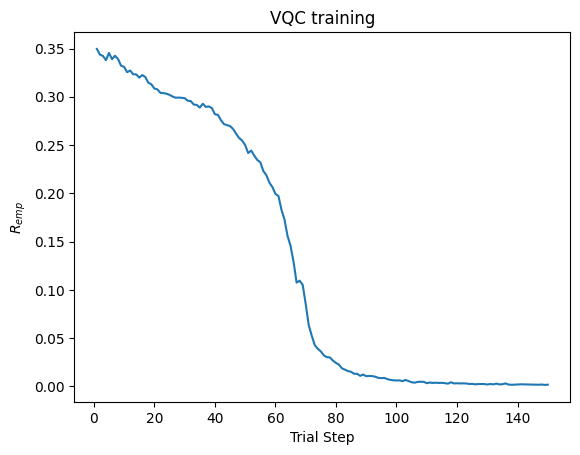

In [20]:
# Plot loss
loss_png = f"{VQC_OUT}/{TEAM_NAME}_loss.png"

fig, ax = plt.subplots()
ax.set_title("VQC training")
ax.set_xlabel("Trial Step")
ax.set_ylabel("$R_{emp}$")
ax.plot(range(1, iterations + 1), costs)
plt.savefig(loss_png)
plt.show()

### <span style="color:red">TODO (4): Evaluate model on remote Braket device</span>

After validating your implementation and successfully training using a local simulator, test your model on remote quantum device using the [Amazon Braket Pennylane plugin](https://github.com/aws/amazon-braket-pennylane-plugin-python). For a full list of available QPUs and simulators, see [Amazon Braket supported devices](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html).

In [21]:
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"                     # SV1
# device = AwsDevice('arn:aws:braket:::device/quantum-simulator/amazon/dm1')            #DM1
# device = AwsDevice('arn:aws:braket:::device/qpu/ionq/ionQdevice')                     #IonQ
# device = AwsDevice('arn:aws:braket:::device/qpu/rigetti/Aspen-11')                    #Rigetti Aspen-11
# device = AwsDevice('arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2')          #Rigetti Aspen M-2

dev_remote = qml.device(
    "braket.aws.qubit",
    device_arn=device_arn,
    wires=20,
    parallel=True,
    max_parallel=20,
    shots=500,
)

qnode_remote = qml.QNode(circuit, dev_remote)


In [22]:
#qnode_remote = qnode_local
#params_csv = f"{VQC_OUT}/{TEAM_NAME}_params.csv"
#costs_csv = f"{VQC_OUT}/{TEAM_NAME}_costs.csv"


In [23]:
# Load trained parameters
loaded_params = np.loadtxt(params_csv)
final_params = loaded_params.reshape(depth + 1, n_wires, 3)

In [24]:
print(final_params)

[[[  3.12094707  -0.8492099    4.87669542]
  [  9.56947882  -1.52478521  -2.44210889]]

 [[  9.92248676   5.49609258  -2.94937003]
  [  3.40900529  -2.04055459  -2.92809074]]

 [[  1.52029379 -12.02149432 -10.83797838]
  [ -3.53295674  -6.36380561   1.97447422]]]


In [25]:
# Calculate accuracy
Y_pred = np.zeros(shape=Y_test.shape)

for ind, x in enumerate(X_test):

    # How many of the qubit states are orthogonal?
    bprobs = qnode_remote(final_params, x)  # probabilities for each basis state
    cprobs = (
        bprobs[0] + bprobs[3],
        bprobs[1] + bprobs[2],
    )  # probabilities for each eigenstate of parity Z_1 Z_2

    # out of the majority of the number shots,
    # classify +1 for orthogonal and -1 for correspondence
    if cprobs[0] >= 0.5:
        Y_pred[ind] = 1.0
    else:
        Y_pred[ind] = -1.0

preds = [1 if Y_pred[i] == Y_test[i] else 0 for i in range(len(Y_pred))]

n_preds = len(Y_pred)
n_correct = sum(preds)
n_incorrect = n_preds - n_correct
accuracy = n_correct / n_preds

print(f"Accuracy: {round(accuracy*100,2)}%")

Accuracy: 100.0%


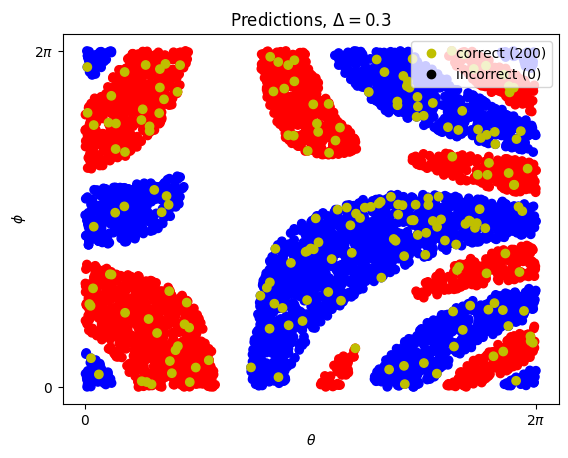

In [26]:
# Plot predictions
preds_png = f"{VQC_OUT}/{TEAM_NAME}_preds.png"

label_correct = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="y",
    markeredgecolor="y",
    label=f"correct ({n_correct})",
)
label_incorrect = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    label=f"incorrect ({n_incorrect})",
)

plt.scatter(xi, xj, marker="o", c=["r" if v == 1 else "b" for v in Ys])
plt.scatter(xi_test, xj_test, c=["y" if v == 1 else "k" for v in preds])
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
plt.legend(handles=[label_correct, label_incorrect], loc="upper right")
plt.title(f"Predictions, $\Delta = {delta}$")
plt.savefig(preds_png)
plt.show()

In [27]:
# check remaining qBraid credits
!qbraid jobs get-credits

You have 1377.394124879972 remaining qBraid credits.
